<a href="https://colab.research.google.com/github/sshersh/ECE-474-Bayes-ML/blob/main/Proj_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import animation
from tqdm import tqdm
from scipy.stats import beta
from scipy.stats import invgamma
from scipy.stats import norm
from scipy.stats import gamma
import os
from matplotlib import rc
rc('animation', html='jshtml')

Leon Fang, Sam Shersher, Jinhan Zhang

In this project, max. likelihood and conjugate prior methods are used to train models for data sampled for binomial and normal distributions, respectively. In the binomial case, the data consists of N Bernoulli trials with an unknown parameter (such as N coin flips with a weighted coin where the weight imbalance is unknown). As more data is sampled, the mean square error of the estimates decreases. 

There are two normal cases: unknown mean and known variance, and vice versa. The same trend occurs with the estimates in the normal cases. 

In both cases, closed form solutions from **Pattern Recognition and Machine Learning** by Bishop are used to update the models. 



```
binomial distribution
https://ocw.mit.edu/courses/mathematics/18-05-introduction-to-probability-and-statistics-spring-2014/readings/MIT18_05S14_Reading14a.pdf
```

```
https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf
```



In [ ]:
# sample data from normal and binomial dists

hyper_params_norm = [[0.5,0.2],[0.4,0.1]]
hyper_params_bin = [0.3, 0.5, 0.7]

N = 1000 # The number of samples
norms = [np.random.normal(mu, sigma, N) for [mu, sigma] in hyper_params_norm]

# ith element of bins is the ith sample from a bernoulli distribution
bins = np.array([
  np.random.binomial(1,theta,N) for theta in hyper_params_bin
])

In [ ]:
# Binomial Fn Defs

# Maximum Likelihood Method

def run_bin_max_likelihood(param_num):
  successes = 0 # cumulative num of successes in N bernoulli trials
  mse_ml = np.zeros(N) # mean square error vector
  for sample_num, data_sample in enumerate(bins[param_num]):
    successes = successes + data_sample
    theta_ml = successes / (sample_num + 1)
    mse_ml[sample_num] = (hyper_params_bin[param_num] - theta_ml)**2

  return mse_ml

# Conjugate Prior Method
# conjugate prior for binomially distributed variable is Beta dist of theta w/ parameters a, b
  
def update_post(m, a, b):
  # update posterior w/ results of single bernoulli trial
  # m is either 0 or 1, representing failure or success
  
  # the conjugate prior for binomial (for N independent bernoulli trials) is beta.
  # the parameters a and b of the beta dist. are updated every time.  
  a_prime = a + m % 2
  b_prime = b + int(not m % 2)
  post = beta(a_prime, b_prime)
  return (a_prime, b_prime, post)

def get_expected_theta(a, b):
  # the expected theta will be the expectation of the posterior once it's been updated
  return a / (a + b)

def run_bin_conj_estimation(param_num):
  # run the conjugate estimation for a binomial r.v with 1 value of theta
  # start w a = 1, b = 1 since beta(1,1) is equivalent to U(0,1).
  a = 1
  b = 1
  posteriors = [beta(a,b)]
  mse_conj = np.zeros(N)
  for sample_num, data_sample in enumerate(bins[param_num]):
    # update the posterior with results of each bernoulli trial, N times
    a, b, new_post = update_post(data_sample, a, b)
    posteriors.append(new_post)
    theta_conj = get_expected_theta(a, b)
    mse_conj[sample_num] = (hyper_params_bin[param_num] - theta_conj)**2

  return mse_conj, posteriors

In [ ]:
def MSE(Y, YH,N):
    result = []
    for i in range(N):
        result.append(np.square(Y[0:i]-YH[0:i]).mean())
    return result

Text(0, 0.5, 'Mean Square Error')

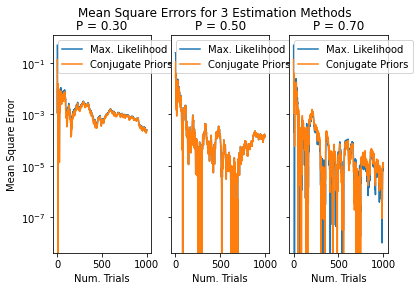

In [ ]:
# Binomial Estimation Example

nparams = len(hyper_params_bin)
fig, ax = plt.subplots(ncols = nparams, sharex=True, sharey=True)
fig.suptitle("Mean Square Errors for %i Estimation Methods" % nparams)

for param_num in range(nparams):
  mse_ml = run_bin_max_likelihood(param_num)
  mse_conj, posteriors = run_bin_conj_estimation(param_num)
  ax[param_num].semilogy(mse_ml, label="Max. Likelihood")
  ax[param_num].semilogy(mse_conj, label="Conjugate Priors")
  ax[param_num].set_title("P = %0.2f" % hyper_params_bin[param_num])
  ax[param_num].set_xlabel("Num. Trials")
  ax[param_num].legend()

ax[0].set_ylabel("Mean Square Error")

In [ ]:
#Generate animation of first 200 posteriors. 

%%capture

from matplotlib import animation

fig = plt.figure()
ax = plt.gca()
lines = ax.plot([],[])

def init():
  return lines

def gen_post_plot(ii):
  ax.clear()
  thetas = np.linspace(0, 1, 100)
  dist = np.array([
    posteriors[ii].pdf(theta) for theta in thetas
  ])
  # ax.plot(thetas, dist)
  ax.set_xlabel(r"$\theta$")
  ax.set_ylabel("Posterior Distribution")
  ax.set_title(r"First 200 Posteriors, $\theta$ = %0.2f" % hyper_params_bin[-1])
  plot, = ax.plot(thetas, dist)
  return plot,

anim = animation.FuncAnimation(fig, gen_post_plot, init_func=init, frames=200, interval=20)

In [ ]:
#play animation of posteriors for binomial r.v

anim

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


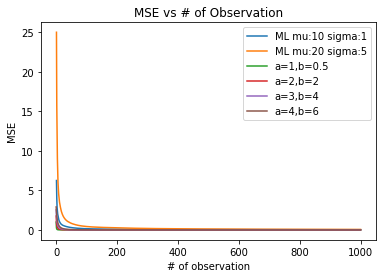

In [ ]:
# normal distribution fixed mu -> need to find var
# prior is gamma

N = 1000
sigma = 2.5
sigma_2 = 5
mu = 10
mu_2 = 20
# real sigma/mu
og_std_array = np.ones(N) * sigma
og_std_array_2 = np.ones(N) * sigma_2


# obs for two set of params
obs = np.random.normal(mu,sigma,N)
obs_2 = np.random.normal(mu_2,sigma_2,N)

std = []
std_prior = []
std_2 = []
std_2_prior = []
mu_array = []
mu_array_2 = []

# find sigma_ML
for i in range(1,N+1):
    std.append(np.std(obs[0:i]))
    std_2.append(np.std(obs_2[0:i]))

# find mse for both ML cases
mse_std_array = MSE(std,og_std_array,N)
mse_std_array_2 = MSE(std_2,og_std_array_2,N)

shape,scale = 2,1   # mean = 2 sigma 2^(0.5)
obs_prior = np.random.gamma(shape,scale,N)
og_std_prior_array = np.ones(N) * np.sqrt(scale)
shape_2,scale_2 = 2,4
obs_prior_2 = np.random.gamma(shape_2,scale_2,N)
og_std_prior_array_2 = np.ones(N) * np.sqrt(scale_2) # ???

for i in range(1,N+1):
    std_prior.append(np.std(obs_prior[0:i]))
    std_2_prior.append(np.std(obs_prior_2[0:i]))


mean = 1
sigma = 0.1
t = 50
obs = 1000
gaus = pd.DataFrame((np.random.normal(mean, sigma, (50, 1000))), dtype=float)
# the hyperparameters a, b
a = [1,2,3,4]
b = [0.5,2,4,6]
# hyperparameters for the conjugate estimate of Gaussian

# acknowledge Ella for this part
a_gauss1 = gaus.copy()
b_gauss1 = gaus.copy()
a_gauss2 = gaus.copy()
b_gauss2 = gaus.copy()
a_gauss3 = gaus.copy()
b_gauss3 = gaus.copy()
a_gauss4 = gaus.copy()
b_gauss4 = gaus.copy()


for i in range(0,t):
    for j in range(0,obs):
        if j==0:
            # error sum--N*sigma_ML
            errSum = (gaus.loc[i,j]-mean)**2
            a_gauss1.loc[i,j] = a[0]+1/2
            b_gauss1.loc[i,j] = b[0]+errSum/2
            a_gauss2.loc[i,j] = a[1]+1/2
            b_gauss2.loc[i,j] = b[1]+errSum/2
            a_gauss3.loc[i,j] = a[2]+1/2
            b_gauss3.loc[i,j] = b[2]+errSum/2
            a_gauss4.loc[i,j] = a[3]+1/2
            b_gauss4.loc[i,j] = b[3]+errSum/2
        else:
            errSum += ((gaus.loc[i,j]-mean)**2)
            a_gauss1.loc[i,j] = a[0]+(j+1)/2
            b_gauss1.loc[i,j] = b[0]+errSum/2
            a_gauss2.loc[i,j] = a[1]+(j+1)/2
            b_gauss2.loc[i,j] = b[1]+errSum/2
            a_gauss3.loc[i,j] = a[2]+(j+1)/2
            b_gauss3.loc[i,j] = b[2]+errSum/2
            a_gauss4.loc[i,j] = a[3]+(j+1)/2
            b_gauss4.loc[i,j] = b[3]+errSum/2


Gmean1 = b_gauss1/a_gauss1.subtract(1)
Gmean2 = b_gauss2/a_gauss2.subtract(1)
Gmean3 = b_gauss3/a_gauss3.subtract(1)
Gmean4 = b_gauss4/a_gauss4.subtract(1)
Gsre1 = (Gmean1-sigma**2)**2
Gsre2 = (Gmean2-sigma**2)**2
Gsre3 = (Gmean3-sigma**2)**2
Gsre4 = (Gmean4-sigma**2)**2
Gmse1 = Gsre1.sum()/t
Gmse2 = Gsre2.sum()/t
Gmse3 = Gsre3.sum()/t
Gmse4 = Gsre4.sum()/t

# find mse for both prior cases
mse_std_prior_array = MSE(std_prior,og_std_array,N)
mse_std_prior_array_2 = MSE(std_2_prior,og_std_array_2,N)
plt.plot(mse_std_array,label = "ML mu:10 sigma:1")
plt.plot(mse_std_array_2,label = "ML mu:20 sigma:5")
plt.xlabel('# of observation')
plt.ylabel('MSE')
plt.title('MSE vs # of Observation')
plt.plot(Gmse1, label='a={},b={}'.format(a[0],b[0]))
plt.plot(Gmse2, label='a={},b={}'.format(a[1],b[1]))
plt.plot(Gmse3, label='a={},b={}'.format(a[2],b[2]))
plt.plot(Gmse4, label='a={},b={}'.format(a[3],b[3]))

# plt.plot(mse_std_prior_array,label = f"Prior mu:{1} sigma:{1}")
# plt.plot(mse_std_prior_array_2,label = f"Prior mu:{4} sigma:{4}")
plt.legend()
plt.show()

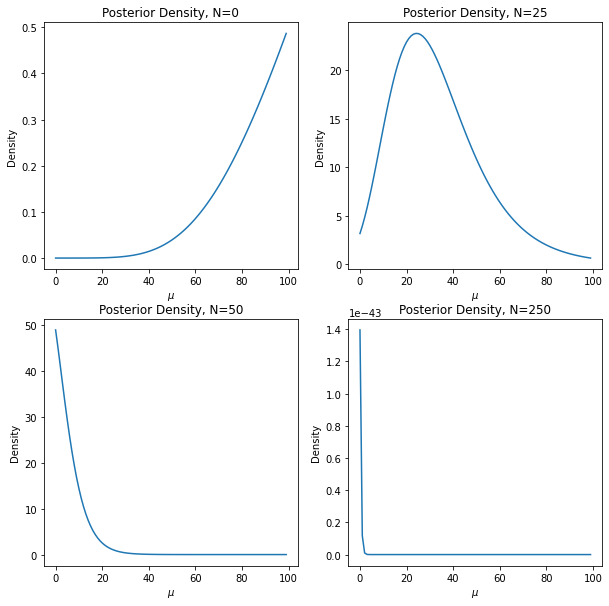

In [ ]:
x_vals = np.linspace(invgamma.ppf(0.01, a_gauss2.loc[0,25]), invgamma.ppf(0.99, a_gauss2.loc[0,25]), 100)
fig3, axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.ravel()

for i in range(0,4):
    index = [0,25,50,250][i]
    
    axs[i].plot(invgamma.pdf(x_vals, a_gauss2.loc[0,index]))
    axs[i].set_title('Posterior Density, N={}'.format(index))
    axs[i].set_xlabel('$\mu$')
    axs[i].set_ylabel('Density')

In [ ]:
def gaussMean(N, sigma, sigma0, mu0, mu_ML):
    m = mu0*sigma**2/(N*sigma0**2+sigma**2)+N*mu_ML*sigma0**2/(N*sigma0**2+sigma**2)
    return m

def gaussVar(N, sigma0, sigma):
    v = 1/sigma0**2+(N/sigma**2)**(-1)
    return v

def mse(obs, pred):
    return np.mean((obs-pred)**2)

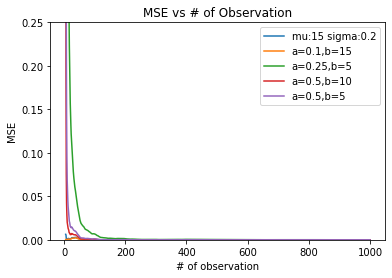

In [ ]:
# normal distribution with unknown mean, known variance
mean = 15
sigma = 0.2
obs = 1000
estimate_ML = []
MSE_ML = []
# prior
gauss = np.random.normal(mean, sigma, obs)


for n in range(1,obs+1):
    est_ML = sum(gauss[0:n])/len(gauss[0:n])
    estimate_ML.append(est_ML)
    MSE_ML.append(np.mean((est_ML-mean)**2))

sigma0 = [0.1, 0.25, 0.5, 0.5]
mu0 = [15,5,10,5]
Gmeans = []
Gmeans_MSE = []
Gvars = []

for i in range(0,4):
    for n in range(1,obs):
        if n==1:
            init_mean = gaussMean(0, mean, sigma0[i], mu0[i], estimate_ML[n])
            Gauss_means = []
            Gauss_vars = []
            Gauss_means_MSE = []
            Gauss_means.append(init_mean)
            Gauss_means_MSE.append(mse(mean, init_mean))
            Gauss_vars.append(gaussVar(0.1, sigma0[i], sigma))
        
        Gauss_mean = gaussMean(n, sigma, sigma0[i], mu0[i], estimate_ML[n])
        Gauss_means.append(Gauss_mean)
        Gauss_var = gaussVar(n, sigma0[i], sigma)
        Gauss_vars.append(Gauss_var)
        Gauss_means_MSE.append(mse(mean, Gauss_mean))
            
    Gmeans.append(Gauss_means)
    Gmeans_MSE.append(Gauss_means_MSE)
    Gvars.append(Gauss_vars)


obs = np.arange(1,obs+1)

plt.plot(obs, pd.Series(MSE_ML).rolling(5).mean(),label='mu:15 sigma:0.2')
for i in range(0,4):
    plt.plot(obs, pd.Series(Gmeans_MSE[i]).rolling(5).mean(),label='a={},b={}'.format(sigma0[i],mu0[i]))
plt.xlabel('# of observation')
plt.ylabel('MSE')
plt.title('MSE vs # of Observation')
plt.legend()
plt.ylim((0,0.25))
plt.show()

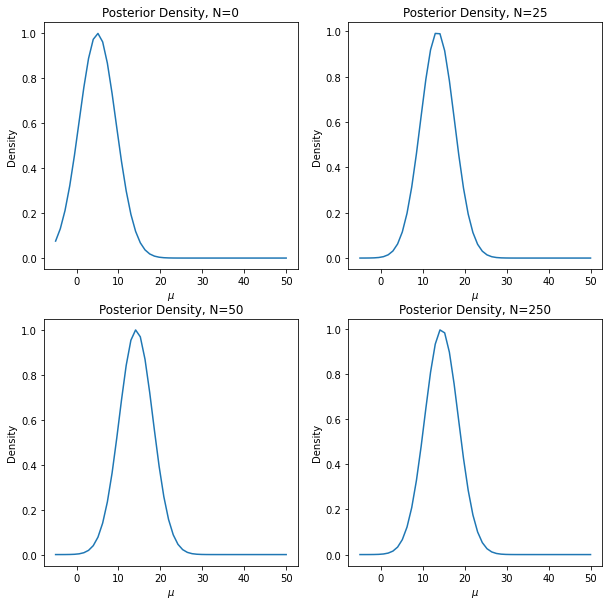

In [ ]:
def plot_gaussian(x, mu, sig):
    return np.exp(-np.power(x-mu,2.)/(2*np.power(sig,2.)))

x_vals = np.linspace(-5, 50, 50)
fig2, axs = plt.subplots(2,2,figsize=(10,10))
axs = axs.ravel()
for i in range(0,4):
    index = [0,25,50,250][i]
    axs[i].plot(x_vals, plot_gaussian(x_vals, Gmeans[3][i], Gvars[3][i]))
    axs[i].set_title('Posterior Density, N={}'.format(index))
    axs[i].set_xlabel('$\mu$')
    axs[i].set_ylabel('Density')

In [ ]:
import imageio
filenames = []
for i in range(0,1000):
    plt.plot(x_vals, plot_gaussian(x_vals, Gmeans[3][i], Gvars[3][i]))
    filename = f'{i}.png'
    filenames.append(filename)
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('pdf_normal.gif', mode='I') as writer:
    for filename in ['1.png', '2.png', '3.png', '4.png']:
        image = imageio.imread(filename)
        writer.append_data(image)

for filename in set(filenames):
    os.remove(filename)


In [ ]:
# heat map generation

# the following are the update equations
def update_mean(n_nut,mu_nut,n,mean):
    return (n_nut*mu_nut + n*mean) / (n_nut + n)
def update_n(n_nut,n):
    return n_nut + n
def update_v(v_nut,n):
    return v_nut+n
def update_sigma(v_nut,n_nut,sigma_nut,square_error,n,mu_nut,mean,v_nut_update):
    return (v_nut*sigma_nut**2 + square_error + ((n_nut*n)/(n_nut+n))*(mu_nut-mean)**2)/v_nut_update
mu = 1
sigma = 2
init_n = 0
init_v = 1
trials = 1000
obs = np.random.normal(mu,sigma,trials)
estimated_mean = []
estimated_n = []
estimated_v = []
estimated_mean.append(obs[0:1])
estimated_sigma = []
estimated_sigma.append(0)
for i in range(1,trials+1):
    curr_obs = obs[:i+1]
    curr_mean = update_mean(init_n,estimated_mean[i-1],i+1,curr_obs.mean())
    mse = ((np.array(curr_obs)-curr_mean)**2).sum()
    estimated_mean.append(curr_mean)
    v_update = update_v(init_v,i+1)
    n_update = update_n(init_n,i+1)
    curr_sigma = (update_sigma(init_v,init_n,estimated_sigma[i-1],mse,i+1,estimated_mean[i-1],curr_mean,v_update))**(0.5)
    estimated_sigma.append(curr_sigma)
    estimated_n.append(n_update)
    estimated_v.append(v_update)
    init_v = v_update
    init_n = n_update

Text(0.5, 0.92, 'obs 600')

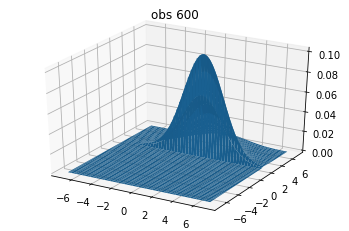

In [ ]:
X = np.linspace(-7,7,1000)
Y = np.linspace(-7,7,1000)
X,Y = np.meshgrid(X,Y)
Z = np.zeros_like(X)
Z_600 = norm.pdf(X,estimated_mean[600],estimated_sigma[600]) * invgamma.pdf(Y,estimated_mean[600],estimated_sigma[600])
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X,Y,Z_600)
plt.title("obs 600")
